In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./filled_survey.csv')

df_correctness = df[[col_name for col_name in df.columns if 'Is the verbalisation correct' in col_name]]
df_fluency = df[[col_name for col_name in df.columns if 'How fluent is the verbalisation' in col_name]]

error_analysis = {
    'grammar_syntax': df[[col_name for col_name in df.columns if 'Grammar/Syntax' in col_name]],
    'omission': df[[col_name for col_name in df.columns if 'Omission' in col_name]],
    'hallucination': df[[col_name for col_name in df.columns if 'Hallucination' in col_name]],
    'other': df[[col_name for col_name in df.columns if 'Other' in col_name]]
}

# Correctness

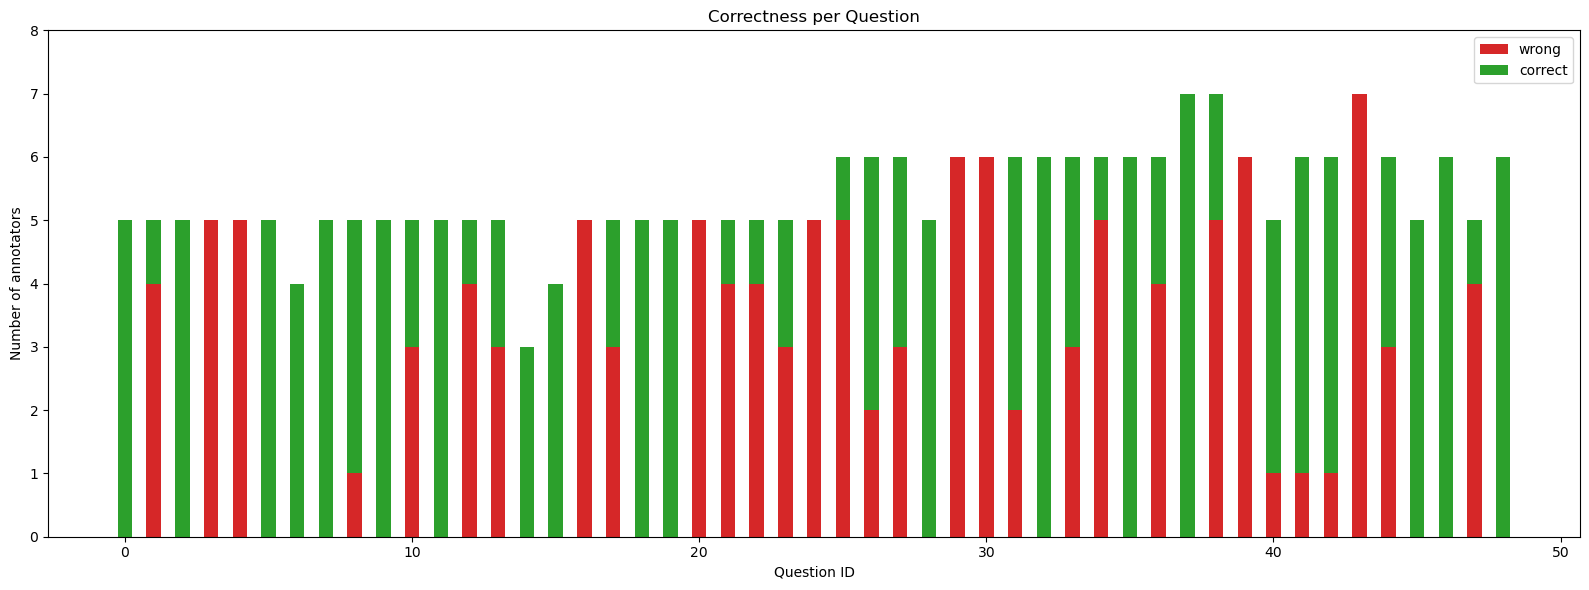

In [21]:
value_counts = [df_correctness[col].value_counts() for col in df_correctness.columns]

correctness_dict = {
    'wrong': [val_count['No'] if 'No' in val_count else 0 for val_count in value_counts],
    'correct': [val_count['Yes'] if 'Yes' in val_count else 0 for val_count in value_counts]
}
questions = np.arange(len(value_counts))

fig, ax = plt.subplots(figsize=(16, 6))
bottom = np.zeros(len(value_counts))

for boolean, weight_count in correctness_dict.items():
    p = ax.bar(questions, weight_count, 0.5, label=boolean, bottom=bottom, color='tab:green' if boolean == 'correct' else 'tab:red')
    bottom += weight_count
plt.ylim(0, 8)
plt.ylabel("Number of annotators")
plt.xlabel("Question ID")
ax.set_title("Correctness per Question")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [16]:
majority_voted = {
    "correct": 0,
    "tie": 0,
    "wrong": 0
}

for corr_votes, wrong_votes in zip(correctness_dict['correct'], correctness_dict['wrong']):
    if corr_votes > wrong_votes:
        majority_voted['correct'] += 1
    elif corr_votes < wrong_votes:
        majority_voted['wrong'] += 1
    else:
        majority_voted['tie'] += 1
        
print(majority_voted)

{'correct': 24, 'tie': 3, 'wrong': 22}


# Fluency

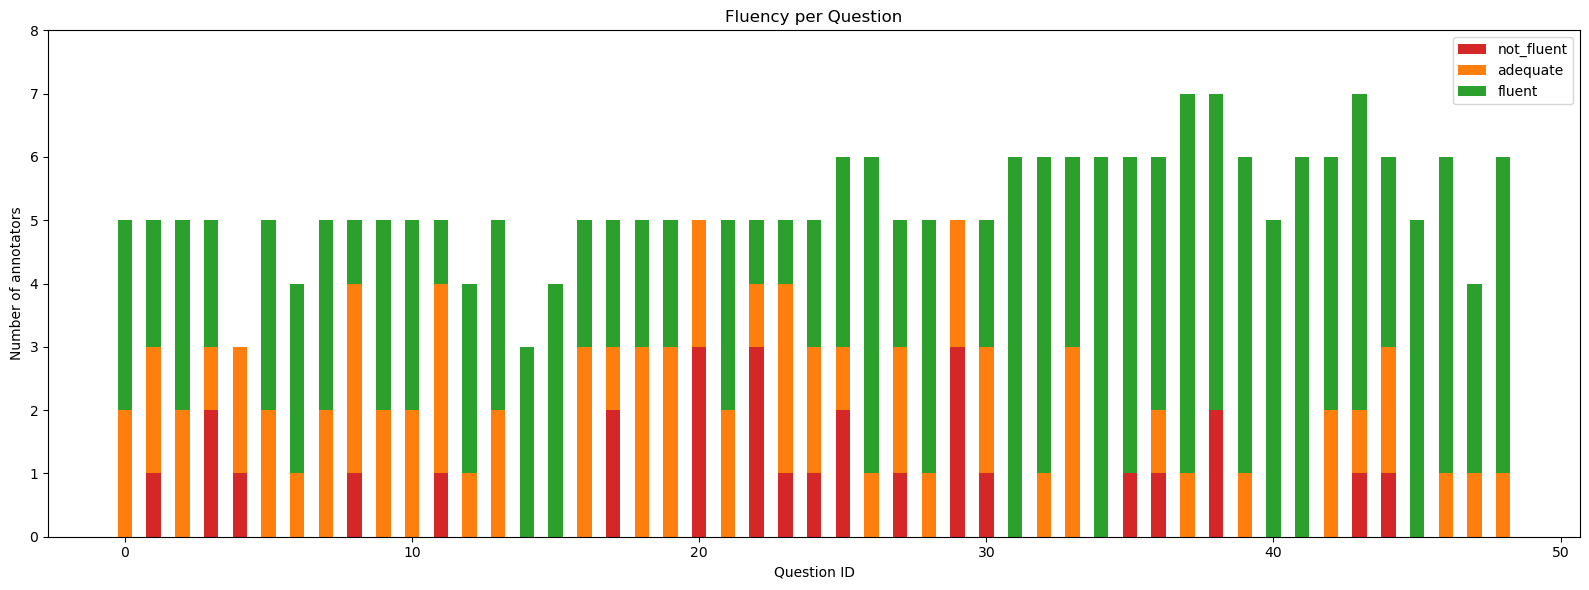

In [22]:
value_counts = [df_fluency[col].value_counts() for col in df_fluency.columns]

fluency_dict = {
    'not_fluent': [val_count['Not fluent'] if 'Not fluent' in val_count else 0 for val_count in value_counts],
    'adequate': [val_count['Adequate'] if 'Adequate' in val_count else 0 for val_count in value_counts],
    'fluent': [val_count['Fluent'] if 'Fluent' in val_count else 0 for val_count in value_counts]
}
questions = np.arange(len(value_counts))

fig, ax = plt.subplots(figsize=(16, 6))
bottom = np.zeros(len(value_counts))

for boolean, weight_count in fluency_dict.items():
    if boolean == 'fluent':
        p = ax.bar(questions, weight_count, 0.5, label=boolean, bottom=bottom, color='tab:green')
    elif boolean == 'adequate':
        p = ax.bar(questions, weight_count, 0.5, label=boolean, bottom=bottom, color='tab:orange')
    elif boolean == 'not_fluent':
        p = ax.bar(questions, weight_count, 0.5, label=boolean, bottom=bottom, color='tab:red')
        
    bottom += weight_count
    
plt.ylim(0, 8)
plt.ylabel("Number of annotators")
plt.xlabel("Question ID")
ax.set_title("Fluency per Question")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [23]:
majority_voted = {
    "fluent": 0,
    "adequate": 0,
    "not fluent": 0
}

for fluent_votes, adequate_votes, not_fluent_votes in zip(fluency_dict['fluent'], fluency_dict['adequate'], fluency_dict['not_fluent']):
    if fluent_votes >= adequate_votes and fluent_votes >= not_fluent_votes:
        majority_voted['fluent'] += 1
    elif adequate_votes > fluent_votes and adequate_votes > not_fluent_votes:
        majority_voted['adequate'] += 1
    elif not_fluent_votes > adequate_votes and not_fluent_votes > fluent_votes:
        majority_voted['not fluent'] += 1
    else:
        print(fluent_votes, adequate_votes, not_fluent_votes)
        
print(majority_voted)

{'fluent': 39, 'adequate': 7, 'not fluent': 3}


# Error Analysis

In [28]:
summed_errors = {key: np.sum(np.sum(df_errors)) for key, df_errors in error_analysis.items()}
summed_errors

{'grammar_syntax': 56.0,
 'omission': 48.0,
 'hallucination': 59.0,
 'other': 16.0}

## Performance Analysis

In [81]:
def produce_barplot(df, col_name):
    distinct_values = sorted(df[col_name].unique())
    fig = plt.figure(figsize=(20, 6))
    
    # Plot correctness
    plt.subplot(1, 2, 1)
    for ind, val in enumerate(distinct_values):
        value_counts = df[df[col_name] == val]['Correctness'].value_counts()
        for default_val in ['Yes', 'No']:
            if default_val not in value_counts:
                value_counts[default_val] = 0
        
        plt.bar([ind], [value_counts['No']], 0.5, label='Wrong' if ind==0 else None , bottom=[0], color='tab:red')
        plt.bar([ind], [value_counts['Yes']], 0.5, label='Correct' if ind==0 else None, bottom=[value_counts['No']], color='tab:green')
        
        plt.text(ind, value_counts['No'] + value_counts['Yes'] + 2, str(int(value_counts['Yes'] / (value_counts['Yes'] + value_counts['No']) * 100)) + '%', fontsize=22, bbox=dict(facecolor='tab:orange', alpha=0.5))
    
    plt.xticks(np.arange(len(distinct_values)), distinct_values,rotation=30)
    
    plt.ylabel('Number of Verbalisations')
    plt.xlabel(col_name)
    
    plt.title(col_name + ' Impact - Correctness')
    plt.legend()
    
    
    # Plot Fluency
    plt.subplot(1, 2, 2)
    for ind, val in enumerate(distinct_values):
        value_counts = df[df[col_name] == val]['Fluency'].value_counts()
        for default_val in ['Not Fluent', 'Adequate', 'Fluent']:
            if default_val not in value_counts:
                value_counts[default_val] = 0
        
        
        plt.bar([ind], [value_counts['Not Fluent']], 0.5, label='Not Fluent' if ind==0 else None , bottom=[0], color='tab:red')
        plt.bar([ind], [value_counts['Adequate']], 0.5, label='Adequate' if ind==0 else None , bottom=[value_counts['Not Fluent']], color='tab:orange')
        plt.bar([ind], [value_counts['Fluent']], 0.5, label='Fluent' if ind==0 else None, bottom=[value_counts['Not Fluent'] + value_counts['Adequate']], color='tab:green')
    
    plt.xticks(np.arange(len(distinct_values)), distinct_values,rotation=30)
    
    plt.ylabel('Number of Verbalisations')
    plt.xlabel(col_name)
    
    plt.title(col_name + ' Impact - Fluency')
    plt.legend()
    
    fig.tight_layout()
    
perf_df = pd.read_csv('./performance_analysis.csv')

### Number of Columns

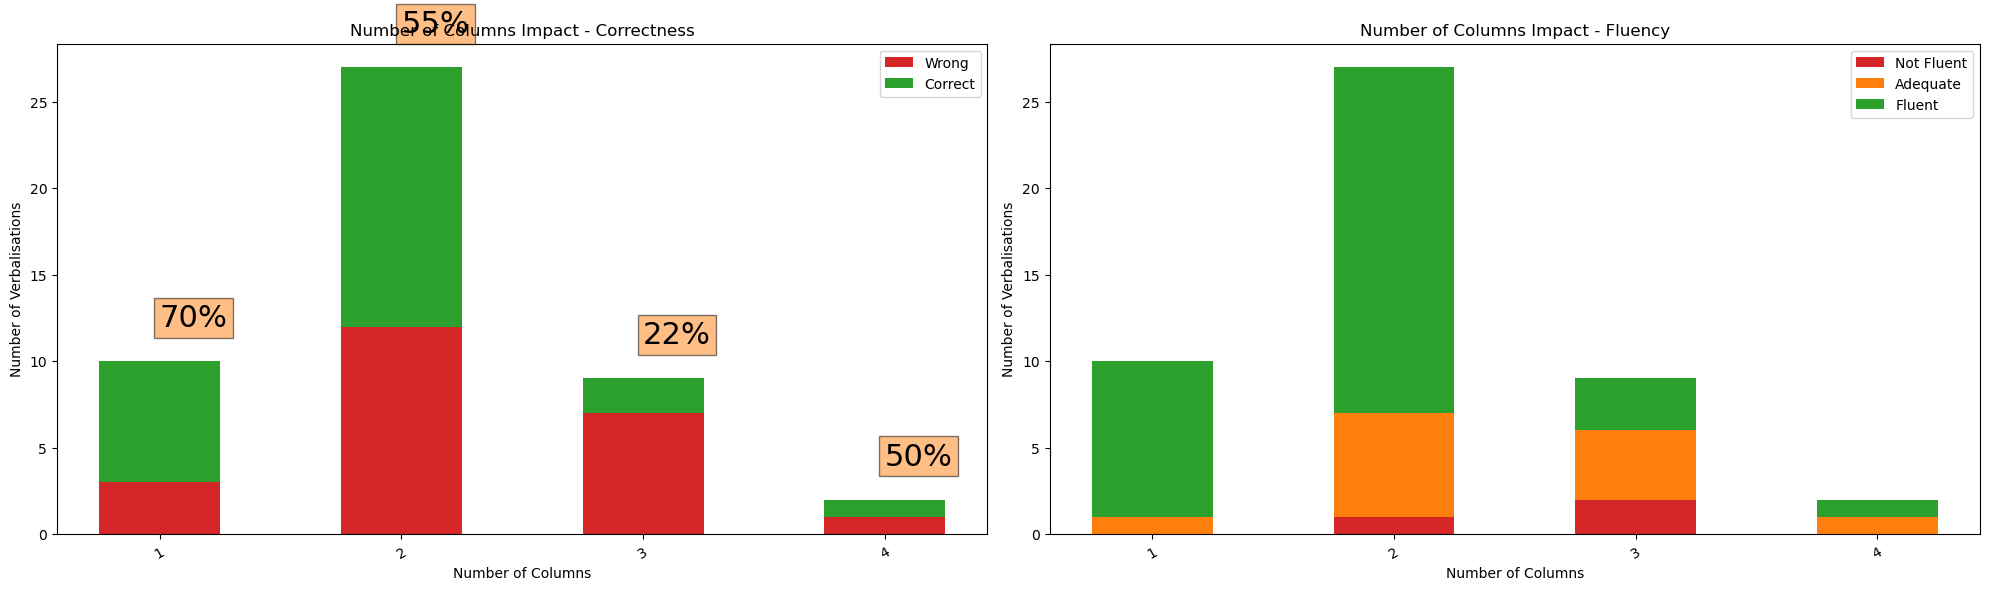

In [83]:
produce_barplot(perf_df, 'Number of Columns')

### Query Type

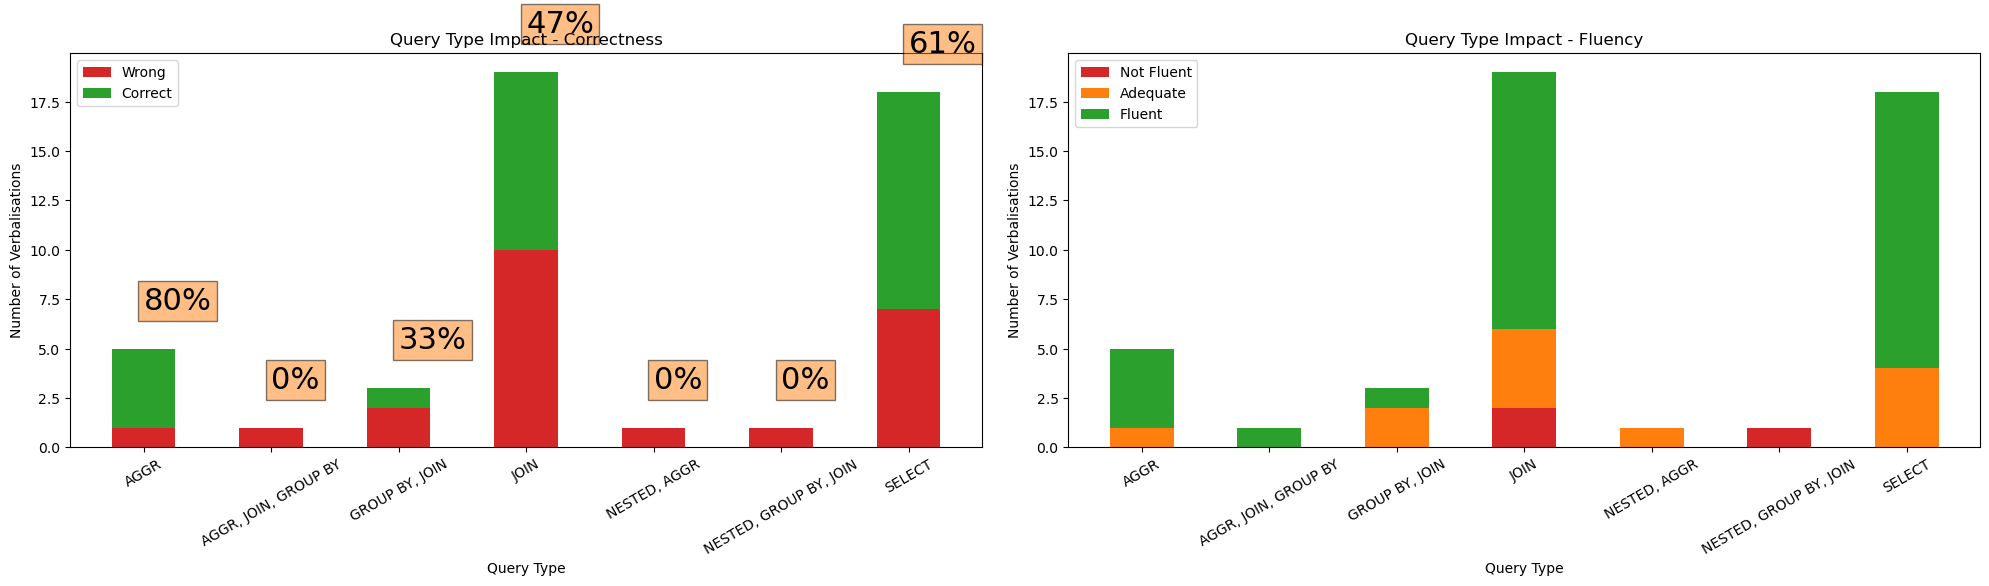

In [84]:
produce_barplot(perf_df, 'Query Type')

### Result Rows

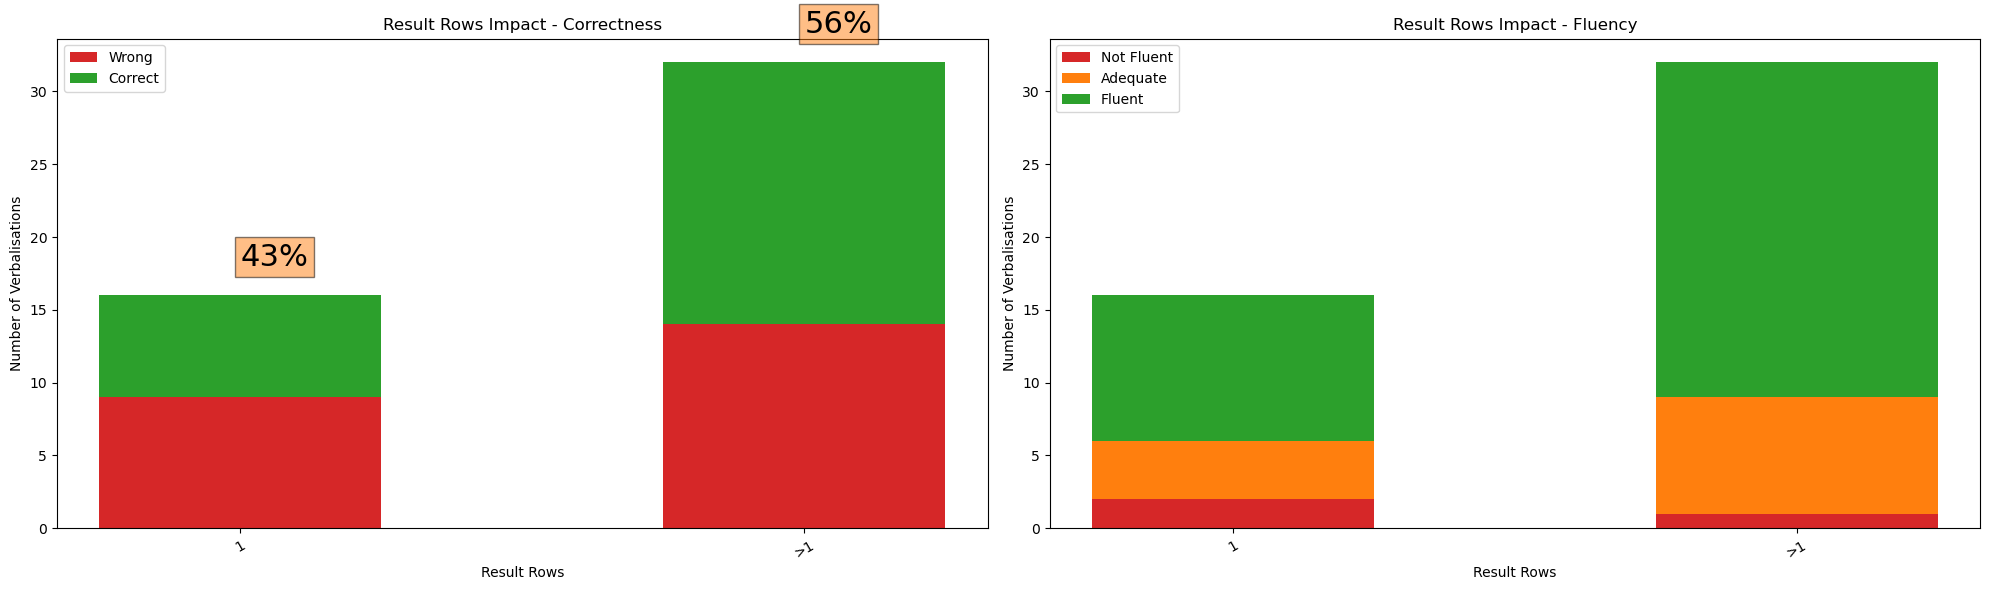

In [85]:
produce_barplot(perf_df, 'Result Rows')

### Has Lengthy Column Value

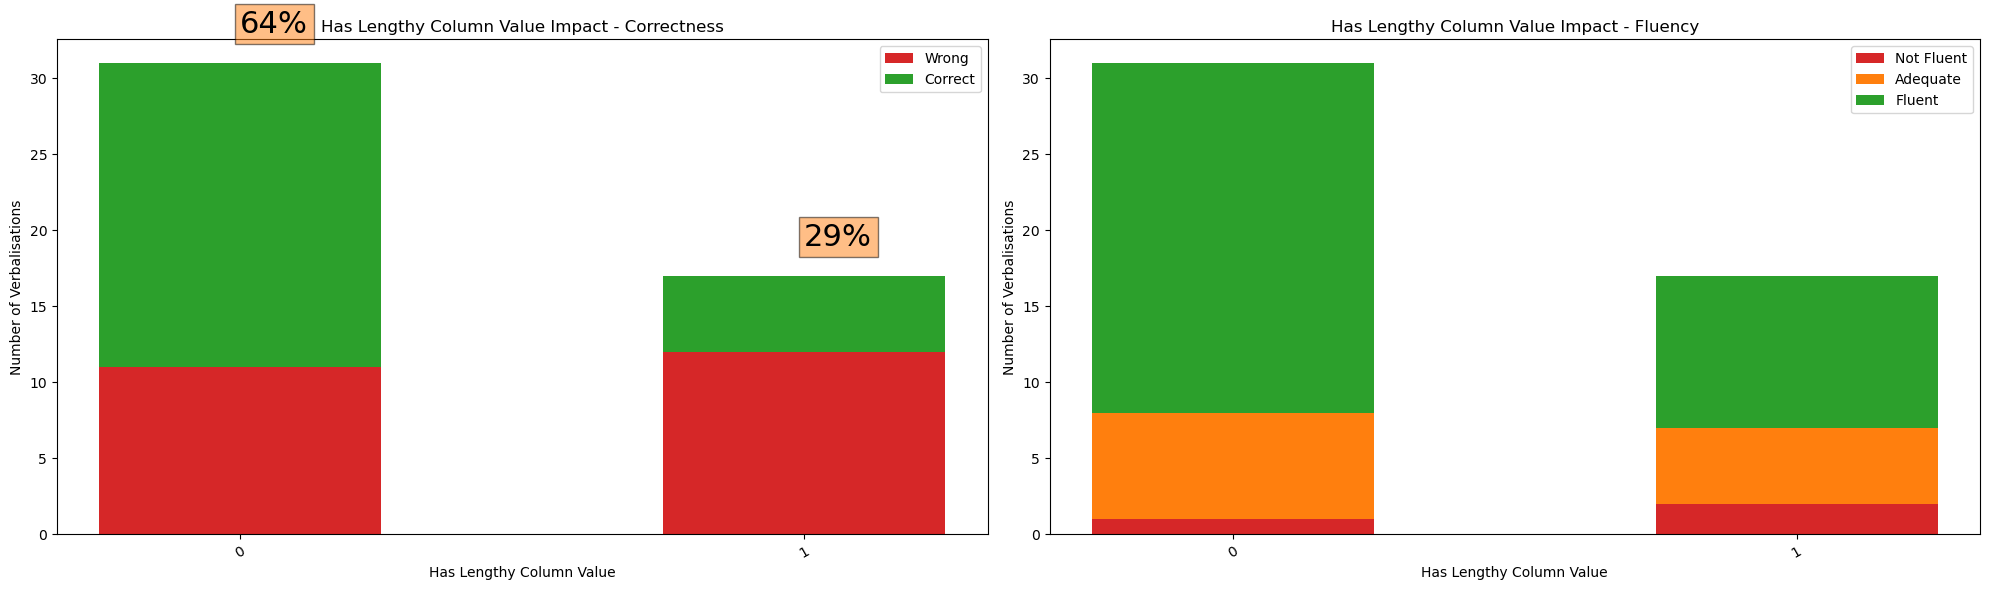

In [86]:
produce_barplot(perf_df, 'Has Lengthy Column Value')

### Has Abbreviation

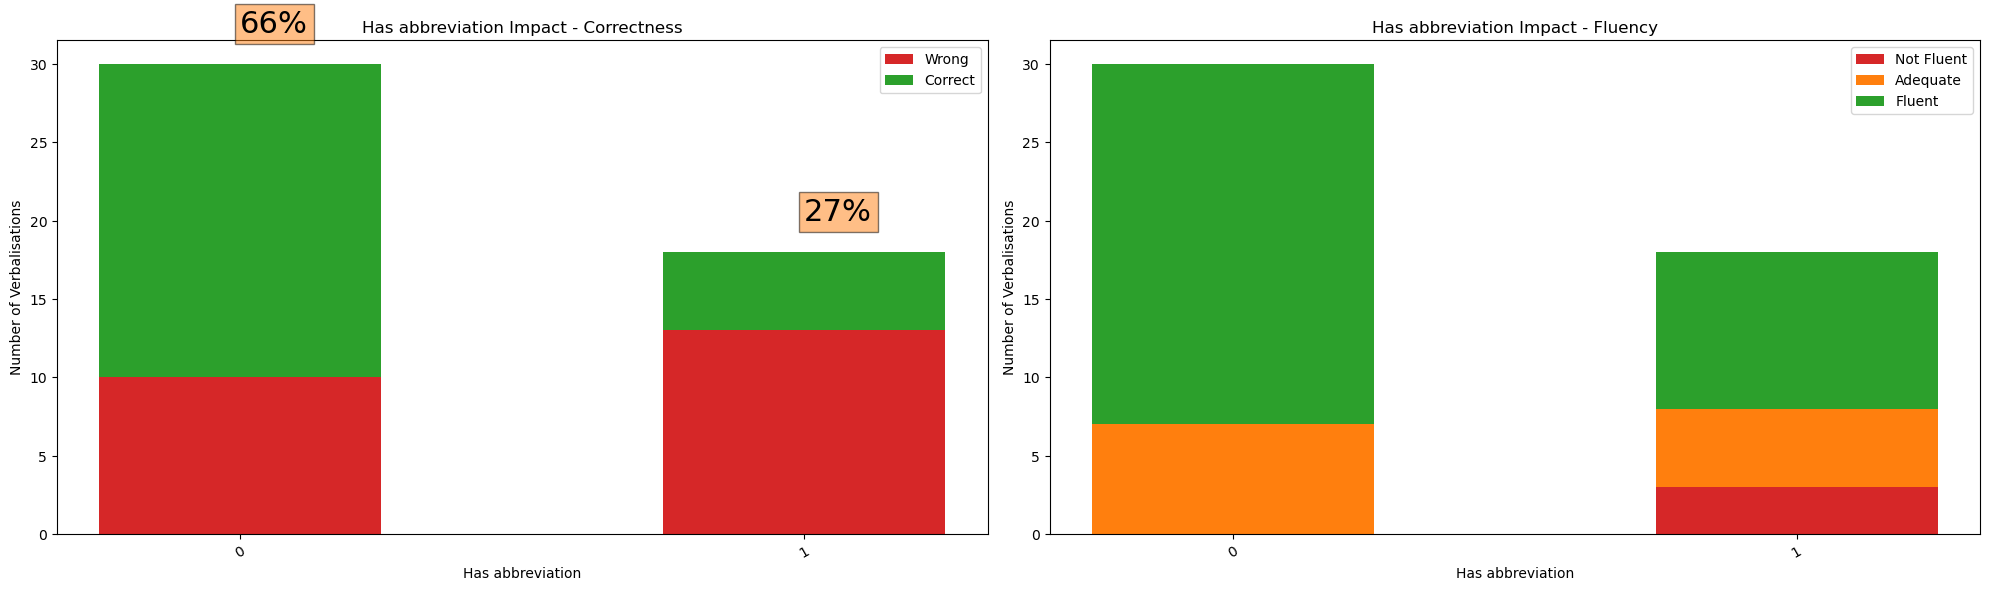

In [87]:
produce_barplot(perf_df, 'Has abbreviation')